In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%run plotting_functions.ipynb

In [3]:
# !!! ONLY RUN THIS FUNCTION ON NON-MASKED DATA SETS !!!
def average_all_dfs(file_names):
    all_dfs = []
    n_sections = 0
    
    for n, file_name in enumerate(file_names):
        df = process_file(file_name)
        
        df = df.loc[:, (df != 0).any(axis=0)] # Remove columns containing only zeros
        
        n_sections += -(len(df.index) // -1440)
        all_dfs += [df]

    sections_array = np.zeros((1440, n_sections))
    i_section = 0

    for df in all_dfs:
        light_on_times = df.index[(df['Light'] == 1) & (df['Light'].shift(1) == 0)]
        
        spiders = df.drop(['Light', 'Day', 'Time'], axis=1)
        combined = spiders.mean(axis=1)

        for on_time in light_on_times:
            section = combined[on_time : on_time + 1440]
            sections_array[:len(section), i_section] = section
            
            i_section += 1

    average_all = sections_array[:, :i_section].mean(axis=1)

    result = pd.Series(average_all)
    
    return result

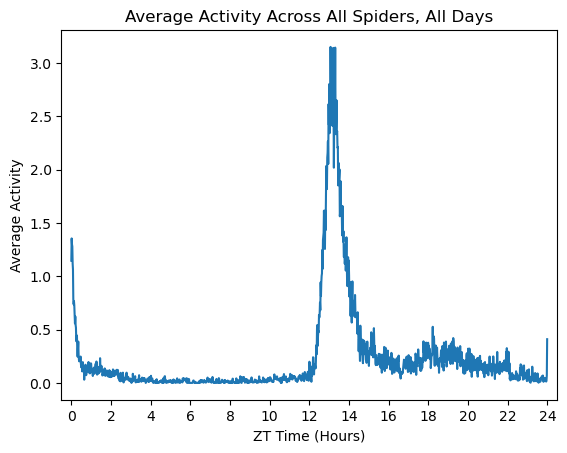

In [4]:
file_names = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

control_avg = average_all_dfs(file_names)

time = control_avg.index
plt.xlim(-.5, 24.5)
plt.xticks(range(0, 25, 2))
plt.xlabel('ZT Time (Hours)')
plt.ylabel('Average Activity')

plt.title('Average Activity Across All Spiders, All Days')

plt.plot(time / 60, control_avg)


In [17]:
def calculate_spider_activity(df, start_time, duration_mins=60):
    start_time = pd.to_datetime(start_time)
    end_time = start_time + pd.Timedelta(minutes=duration_mins)
    
    mask = (df['Time'] >= start_time) & (df['Time'] < end_time)
    df_filtered = df.loc[mask]
    
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    average_activity = df_filtered[spider_columns].mean()
    return average_activity

In [6]:
def get_first_lightson(df):
    lights = df['Light']
    light_on_times = df.index[(lights == 1) & (lights.shift(1) == 0)]
    return df['Time'][light_on_times[0]]

In [15]:
def get_masking_data(pulse_file, control_avg_series, duration_mins=60):
    pulse_df = process_file(pulse_file)
    pulse_start = get_masking_bounds(pulse_df)[0]
    
    zt_start = get_first_lightson(pulse_df)

    pulse_start_zt_mins = int((pulse_start - zt_start).total_seconds() // 60) % 1440

    activities = calculate_spider_activity(pulse_df, pulse_start, duration_mins)

    control_avg_pulsetime = control_avg_series[pulse_start_zt_mins : pulse_start_zt_mins + duration_mins].mean()

    return pulse_start_zt_mins, control_avg_pulsetime, activities

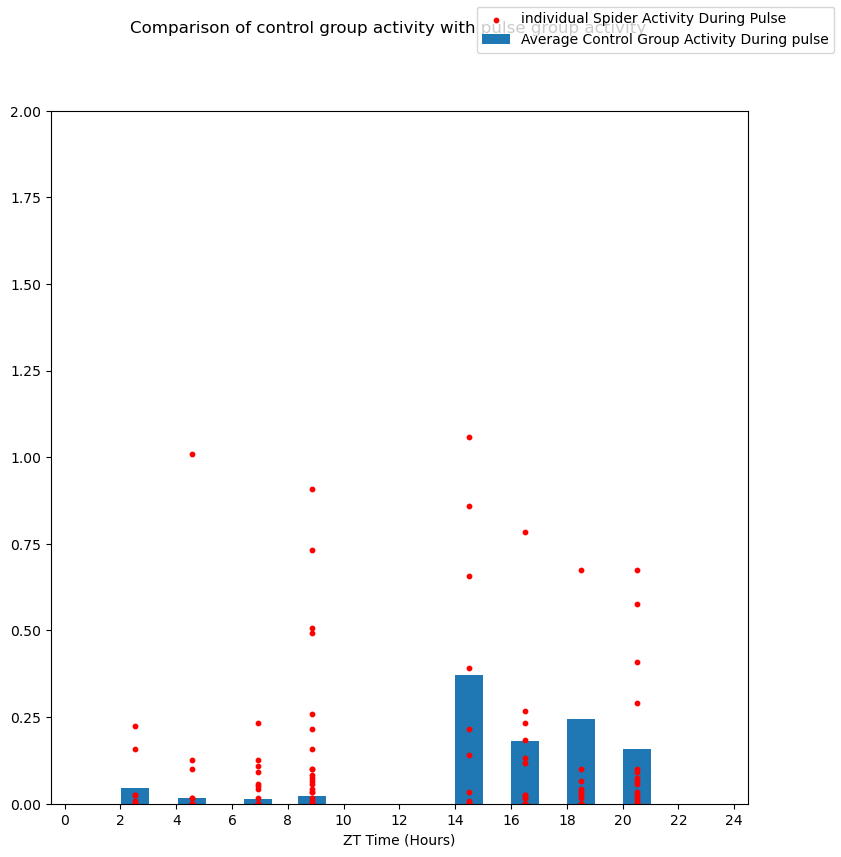

In [23]:
files = ['Steatoda A masking midnight.txt', 'Steatoda B maskng 2am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking 10 am - extra hour removed.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda A masking 02 pm.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt']
         
nopulse_files = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

ctrl = average_all_dfs(nopulse_files)

times = []
bars = []
scatters = []

for file in files:
    time, control_avg, activity = get_masking_data(file, ctrl, duration_mins=120)

    times += [time / 60 + .5]
    bars += [control_avg]
    scatters += [activity]

fig, ax = plt.subplots()

ax.set_xlim(-.5, 24.5)
ax.set_xticks(range(0, 25, 2))
ax.set_xlabel('ZT Time (Hours)')
ax.set_ylim(0, 2)

bars = ax.bar(times, bars, width=1, label='Average Control Group Activity During pulse')
_ = ax.scatter(None, None, color='red', s=10, label='individual Spider Activity During Pulse')

for (time, points) in zip(times, scatters):
    ax.scatter([time for _ in points], points, color='red', s=10)

fig.suptitle('Comparison of control group activity with pulse group activity')
fig.legend()
fig.set_size_inches(9, 9)

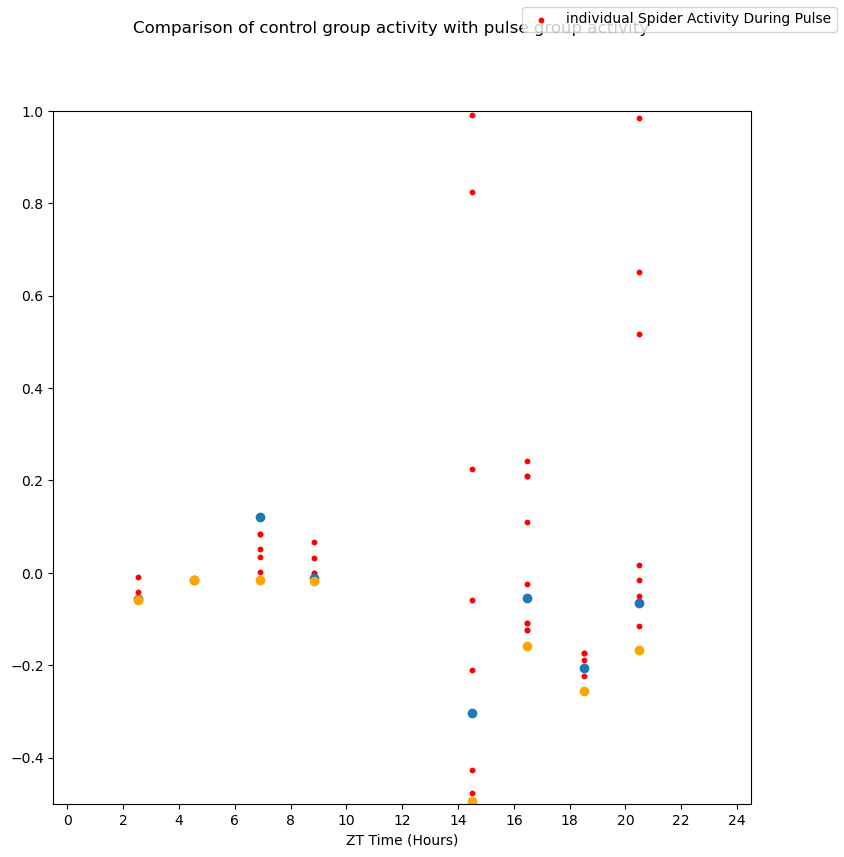

In [46]:
files = ['Steatoda A masking midnight.txt', 'Steatoda B maskng 2am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking 10 am - extra hour removed.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda A masking 02 pm.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt']
         
nopulse_files = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

ctrl = average_all_dfs(nopulse_files)

times = []
bars = []
scatters = []

for file in files:
    time, control_avg, activity = get_masking_data(file, ctrl, duration_mins=60)

    times += [time / 60 + .5]
    bars += [control_avg]
    scatters += [activity]

fig, ax = plt.subplots()

ax.set_xlim(-.5, 24.5)
ax.set_xticks(range(0, 25, 2))
ax.set_xlabel('ZT Time (Hours)')
ax.set_ylim(-.5, 1)

_ = ax.scatter(None, None, color='red', s=10, label='individual Spider Activity During Pulse')

means = [pts.mean() - bar for pts, bar in zip(scatters, bars)]
medians = [pts.median() - bar for pts, bar in zip(scatters, bars)]


for (time, points, bar) in zip(times, scatters, bars):
    ax.scatter([time for _ in points], points - bar, color='red', s=10)

plt.scatter(times, means)
plt.scatter(times, medians, color='orange')

fig.suptitle('Comparison of control group activity with pulse group activity')
fig.legend()
fig.set_size_inches(9, 9)